# Lab 2: Quantization and entropy coding

This lab aims to get familiar with the quantization of sound signal and with entropy coding, in particular Huffman coding.

## Relevant concepts:

### Quantization noise
Noise resulting from quantizing a signal.

### Signal to Noise Ratio (SNR)
A measure that compares the level of a desired signal to the level of background noise. SNR is defined as the ratio of signal power to noise power, often expressed in decibels. A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise.

### Entropy
Signal entropy is the minimum number of bits required to describe a encode a signal. It has its maximum value when all probabilities are equal (we assume the number of possible states. is finite), and the resulting value for entropy is the logarithm of the number of states.

### Huffman coding
A data compression method, independent of data type, that is commonly used for lossless data compression.

In [1]:
# for using colab need to uncomment this
# !git clone https://github.com/xserra/audio-coding-materials.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
import heapq
from collections import Counter

In [3]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
  plt.show()

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  window = get_window('hann', sound_array.size)
  spectrum = fft(window*sound_array)
  magnitude_spectrum= 20*np.log10(abs(spectrum[:spectrum.size//2]))

  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  sample_index = 0
  window = get_window('hann', fft_size)
  magnitude_spectrogram = []
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum= 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

# Part 1 Scalar quantization
Explore the impact of quantization in a sound file by measuring its SNR. Modify the code given as needed and answer the questions given.

In [4]:
def quantize_signal(x, original_bits, target_bits):
  """Quantizes a signal x, assuming it originally had original_bits bits per sample, to target_bits per sample.
  Args:
    x (numpy.array): Array of samples as floating point values between -1 and 1
    original_bits (int): Number of bits of the signal that x represents
    target_bits (int): Number of bits per sample of the output signal
  """
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output

def calculate_snr(x, y):
    """Calculate the Signal-to-Noise Ratio (SNR) of a quantized signal.
    Args:
    x (numpy.array): The original signal
    y (numpy.array): The quantized signal
    Returns:
    snr_db (float): The SNR in decibels (dB)
    """
    # Ensure that x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    # Calculate the signal power (mean squared value of the original signal)
    signal_power = np.mean(x ** 2)
    # Calculate the noise power (mean squared difference between original and quantized signal)
    noise_power = np.mean((x - y) ** 2)
    # Compute the SNR
    snr = signal_power / noise_power
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    return snr_db

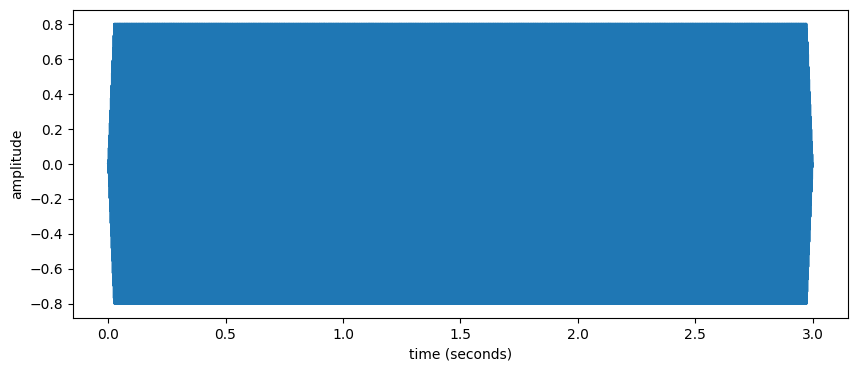

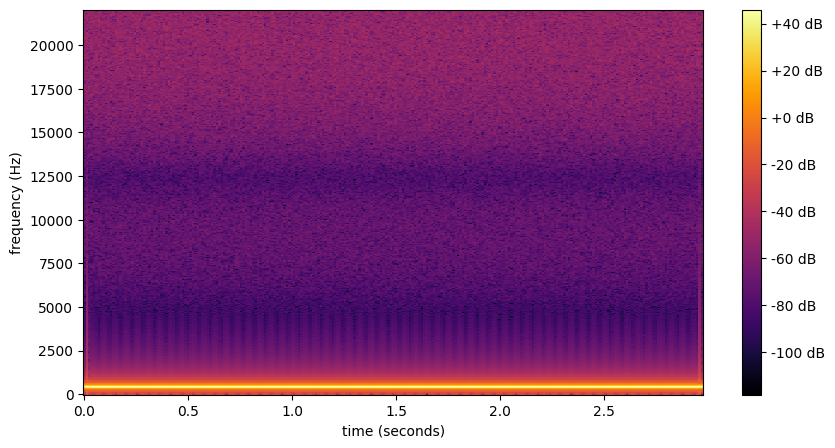

In [5]:
# read and display a sound
#sound_array, sampling_rate = read_sound('../sounds/721313-hangpan.wav')
#sound_array, sampling_rate = read_sound('../sounds/synthetic.wav')
sound_array, sampling_rate = read_sound('../sounds/sinewave.wav')
display_sound(sound_array,sampling_rate)
display_spectrogram(sound_array, 512, 1024, sampling_rate)

SNR: 43.904104232788086 dB


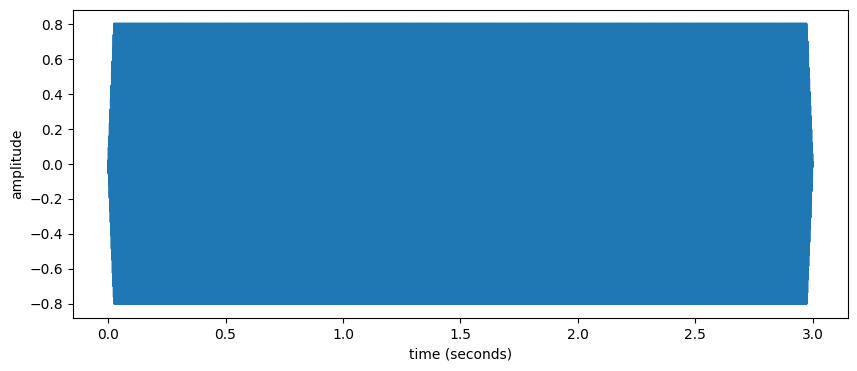

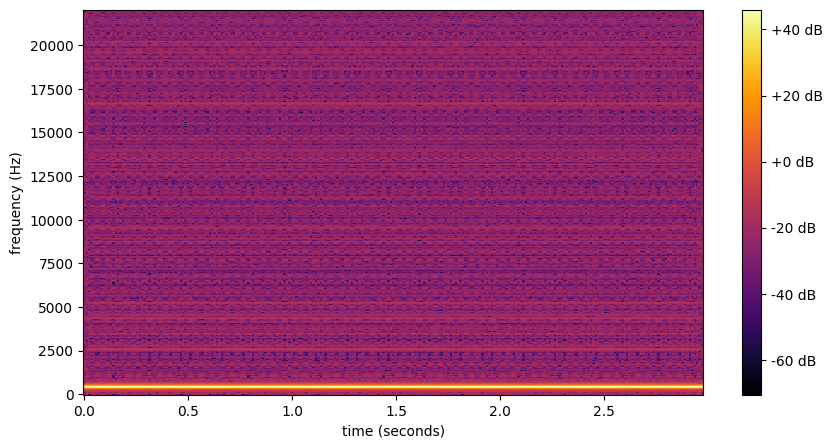

In [6]:
# quantize the sound (originally at 16 bits) to progressively fewer number of bits
# until you star hearing the quantization noise and compute its SNR
number_of_bits = 7
quantized_sound_array = quantize_signal(sound_array, 16, number_of_bits)

# compute SNR
snr = calculate_snr(sound_array, quantized_sound_array)
print("SNR: %r dB" %snr)

# display quantized sound
display_sound(quantized_sound_array,sampling_rate)
display_spectrogram(quantized_sound_array, 512, 1024, sampling_rate)

**Questions: (answer in this text cell)**

1. What is the lowest bit rate at which you start hearing the quantization noise? Explain the result using the SNR value and the spectrogram.

2. Try the same bit rate change for synthetic.wav? Does it result into the same SNR? Do you hear the quantization noise equally? If not, explain why not?
---

# Part 2 - Entropy calculation

Compute the probability distributions and the entropy of different signals. Correlate these measurements with the characteristics of the sounds. Answer the questions given and modify the code to support your answers.

In [7]:
def calculate_entropy(probs):
    """
    Args:
        probs (np.array): Array of probs. for each symbol in the source
    Returns:
        H (float): entropy value
    """
    H = 0
    for p in probs:
      if(p > 0):
        H -= p * np.log2(p)
      elif(p < 0):
        return np.nan
    return H

def get_prob_per_symbol(y):
    """ Get symbol occurrence probability
    Args:
        x (np.array): Input signal
    Returns:
        (np.array, np.array): (sorted symbols, corresponding probabilities)
    """
    symbols, count = np.unique(y, return_counts=True)
    probs = count / sum(count)
    return symbols, probs

/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_27010/1161847639.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, x = read(file)


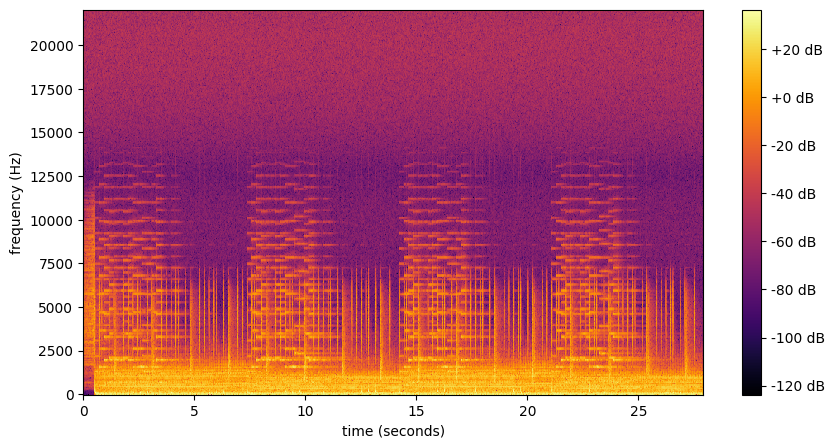

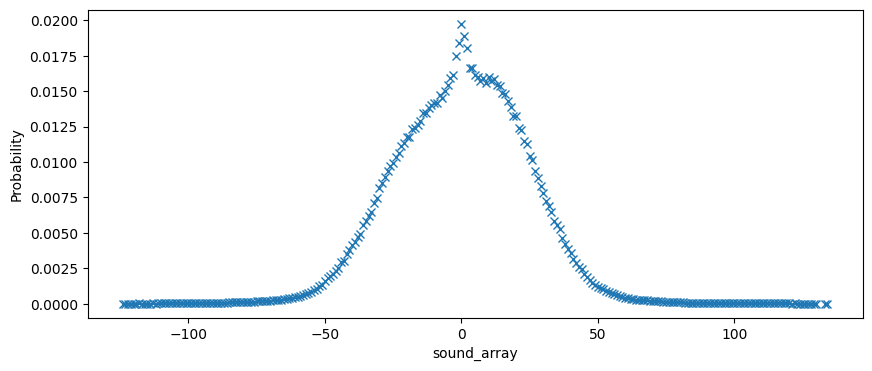

Entropy: 6.580733453476906


In [8]:
# read a sound
#sound_array, sampling_rate = read_sound('../sounds/721313-hangpan.wav')
#sound_array, sampling_rate = read_sound('../sounds/synthetic.wav')
#sound_array, sampling_rate = read_sound('../sounds/406609-tuba.wav')
sound_array, sampling_rate = read_sound('../sounds/750340-background-music.wav')

display_spectrogram(sound_array, 512, 1024, sampling_rate)

# Quantize the sound_array by giving the number of bits to use
nbits = 8
x_scaled = sound_array * 2**nbits
x_quantized = np.int16(np.round(x_scaled))

# compute the probabilities of all the signal values
symbols, probs = get_prob_per_symbol(x_quantized)

plt.figure(0, figsize=(10, 4))
plt.plot(symbols, probs, 'x')
plt.xlabel("sound_array"), plt.ylabel("Probability")
plt.show()

# compute the entropy value
h = calculate_entropy(probs)
print("Entropy:", h)

**Questions:**

1. Choose 3 sounds from the ones given in the repository that would result in distinct probabilty distributions. Compute their probability distributions and describe their similarities and differences. Show the plots in the cell above of all the results and explain them here.

2. For one of the sounds, change the number of "symbols" used by changing the quantization value. Give the resulting number of symbol. Compare the resulting probability distributions for the different quantizations. Explain the result.

3. Compute the entropy values of the distributions obtained in question 1 and explain the relation between the entropy values obtained and the shape of the probability distributions.

# Part 3 Huffman encoding
Encode and decode a signal using Huffman coding and understand its effectiveness in different type of sounds. Answer the questions given and modify the code to support your answers.

In [9]:
# functions used to implement huffman coding with the heap queue algorithm
# (priority queue algorithm)

# Define a tree node
class Node:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left  # left child
        self.right = right  # right child

    # Override the less-than operator for the priority queue to work
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(char, freq) for char, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.freq + right.freq, left, right)
        heapq.heappush(heap, merged)

    return heap[0]

def generate_huffman_codes(node, prefix="", code_map={}):
    if node is None:
        return

    if node.char is not None:
        code_map[node.char] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", code_map)
        generate_huffman_codes(node.right, prefix + "1", code_map)

    return code_map

def encode(array, code_map):
    return ''.join(code_map[char] for char in array)

def decode(encoded_string, root):
    decoded_array = []
    node = root
    for bit in encoded_string:
        if bit == '0':
            node = node.left
        else:
            node = node.right

        if node.char is not None:
            decoded_array.append(node.char)
            node = root

    return decoded_array

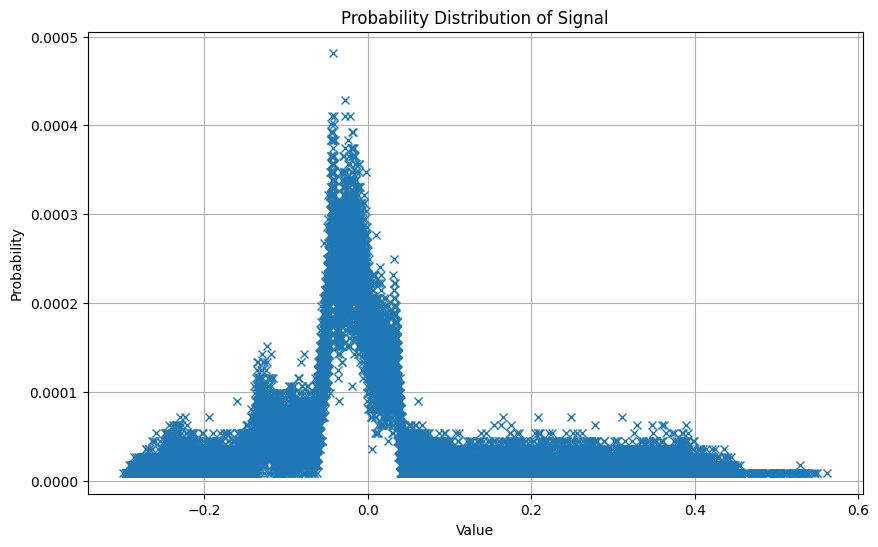

Original Size (bits): 1793216
Encoded Size (bits): 1499633
Compression Ratio: 1.20
Compression Percentage: 16.37%


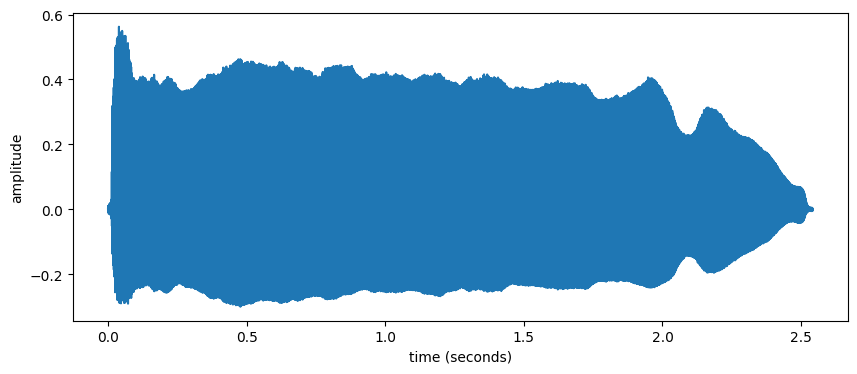

In [10]:
x, fs = read_sound('../sounds/487465-trumpet.wav')

# Step 1: Calculate frequencies of each signal value
frequencies = Counter(x)
total_samples = len(x)
probabilities = {key: freq / total_samples for key, freq in frequencies.items()}

# Plot the probability distribution
plt.figure(figsize=(10, 6))
plt.plot(probabilities.keys(), probabilities.values(), 'x')
plt.title("Probability Distribution of Signal")
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

# Step 2: Build the Huffman tree
root = build_huffman_tree(frequencies)

# Step 3: Generate Huffman codes
huffman_codes = generate_huffman_codes(root)

# Step 4: Encode the input array
encoded_x = encode(x, huffman_codes)

# Step 5: Decode the encoded string
decoded_x = np.array(decode(encoded_x, root))

# Calculate the size of the original signal
original_size_bits = len(x) * 16

# Calculate the size of the Huffman encoded signal
encoded_size_bits = len(encoded_x)

# Calculate the compression ratio
compression_ratio = original_size_bits / encoded_size_bits
compression_percentage = (1 - (encoded_size_bits / original_size_bits)) * 100

print(f"Original Size (bits): {original_size_bits}")
print(f"Encoded Size (bits): {encoded_size_bits}")
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"Compression Percentage: {compression_percentage:.2f}%")

display_sound(decoded_x, fs)
ipd.display(ipd.Audio(data=decoded_x, rate=fs))

**Questions:**

1. Using the same 3 sounds choosen in Part 2, encode and decode them using Huffman coding. How many Huffman codes where created for each sound. Why different sounds result in different number of codes? Add the code to calculate the number of codes for each sound and explain the results.

2. What is the compression percentage obtained for each sound. Compare the results with the ones for question 1 and explain it.

3. Choose one of the sounds, change its sampling rate to half (22050Hz) and the number of bits per sample to half (8 bits). Perform the Huffman coding on the modified sund and explain the compression percentage obtained. Compare it with the one obtained with the original sound.
---